In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import scvi
from feature_attribution_sc.explainers.mask import mask, generate_rankings
from feature_attribution_sc.models.scgen_models import SCGENCustom

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/pytorch_lightning/__init__.py:28: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  ja

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# data_path='/home/yuge/feature-attribution-sc'
data_path = '/home/icb/yuge.ji/projects/feature-attribution-sc'

feature_importance_files = [
#     f'{data_path}/outputs/baselines/task2_random.csv',
    f'{data_path}/outputs/differential_expression/task2_DE_cell_types.csv',
#     f'{data_path}/outputs/ablation/task2_abs.csv'
#     f'{data_path}/outputs/expected_gradients/task2_absolute_sum_expected_grads.csv'
]

thresholds = list(range(0, 100, 40)) + [99]
thresholds

[0, 40, 80, 99]

In [4]:
hlca_path = '../datasets/hlca.h5ad'
adata = sc.read(hlca_path)
adata

AnnData object with n_obs × n_vars = 584944 × 2000
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_ne

In [5]:
model = scvi.model.SCANVI.load('../models/scanvi_model/', adata)

INFO     File ../models/scanvi_model/model.pt already downloaded                                                   


/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scvi/data/_utils.py:156: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scvi/data/_utils.py:156: UserWarning: Category 18 in adata.obs['_

## Mask and perform label transfer

In [6]:
def perform_label_transfer(ref_emb, query_emb, cell_type_column, k=15):
    # calculate an object representing the joing neighbor graph of ref + query
    try:
        ing = sc.tl.Ingest(ref_emb)
    except ValueError:
        print('Failed to ingest due to duplicate cell embeddings.')
        return None
#     ing.fit(query_emb)
#     ing.neighbors(k=k)
    # calculate distances to top k neighbors for each cell and store indices
    # of neighbor cells
    top_k_indices, top_k_distances = ing._nnd_idx.query(ref_emb.X, k, epsilon=.1) #(
#         ing._distances,
#         ing._indices,
#     )
    # transform distances with Gaussian kernel (?)
    stds = np.std(top_k_distances, axis=1)
    stds = (2.0 / stds) ** 2  # don't know why the first 2.0
    stds = stds.reshape(-1, 1)
    top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))
    # normalize so that transformed distances sum to 1
    weights = top_k_distances_tilda / np.sum(
        top_k_distances_tilda, axis=1, keepdims=True
    )
    # initialize empty series to store predicted labels and matching
    # uncertaintites for every query cell
    uncertainties = pd.Series(index=query_emb.obs_names, dtype="float64")
    pred_labels = pd.Series(index=query_emb.obs_names, dtype="object")
    # now loop through query cells
    y_train_labels = ref_emb.obs[cell_type_column].values
    for i in range(len(weights)):
        # store cell types present among neighbors in reference
        unique_labels = np.unique(y_train_labels[top_k_indices[i]])
        # store best label and matching probability so far
        best_label, best_prob = None, 0.0
        # now loop through all cell types present among the cell's neighbors:
        for candidate_label in unique_labels:
            candidate_prob = weights[
                i, y_train_labels[top_k_indices[i]] == candidate_label
            ].sum()
            if best_prob < candidate_prob:
                best_prob = candidate_prob
                best_label = candidate_label
        else:
            pred_label = best_label
        # store best label and matching uncertainty
        uncertainties.iloc[i] = max(1 - best_prob, 0)
        pred_labels.iloc[i] = pred_label
    # print info
    print(
        "Storing transferred labels in your query adata under .obs column:",
        f"transf_{cell_type_column}",
    )
    print(
        "Storing label transfer uncertainties in your query adata under .obs column:",
        f"transf_{cell_type_column}_unc",
    )
    # store results
    query_emb.obs[f"transf_{cell_type_column}"] = pred_labels
    query_emb.obs[f"transf_{cell_type_column}_unc"] = uncertainties

In [7]:
def generate_masked_inputs(rankings, gene_indices, df, thresholds, class_label='labels'):
    """Returns the masked inputs given rankings from an attribution file.
    
    Masking can take a while to iterate over all tensors.
    
    Params
    ------
    thresholds : list of percentages at which to remove features
    class_label : str
        Batch label which contains the class information used for masking.
    """
    incremental_sparsity = []
    masked_inputs = {}
    for threshold in thresholds:
        t = float(threshold)/100
        print(t)
        masked_inpt = mask(
            batch['X'], batch[class_label], df, rankings, gene_indices, threshold=t)

        # store input for later use
        masked_inputs[f'masked_{threshold}'] = masked_inpt

        # record the sparsity for plotting. only applicable if we're masking with zeroes
        sparsity_after = np.count_nonzero(masked_inputs[f'masked_{threshold}']) / (adata.shape[0] * adata.shape[1])
        incremental_sparsity.append((t, sparsity_after))
        
    return masked_inputs, incremental_sparsity

In [8]:
sparsity_before = adata.X.nnz / (adata.shape[0] * adata.shape[1])
sparsity_before

0.09254418115238382

In [9]:
batch_size = adata.shape[0]
scdl = model._make_data_loader(adata=adata, indices=list(range(adata.shape[0])), batch_size=batch_size)
batch = next(scdl.__iter__())

/home/icb/yuge.ji/projects/feature-attribution-sc/outputs/differential_expression/task2_DE_cell_types.csv
Generating rankings for 29 labels and 2000 features.
0.0


/home/icb/yuge.ji/projects/feature-attribution-sc/feature_attribution_sc/explainers/mask.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(masked_data)


0.4
0.8
0.99


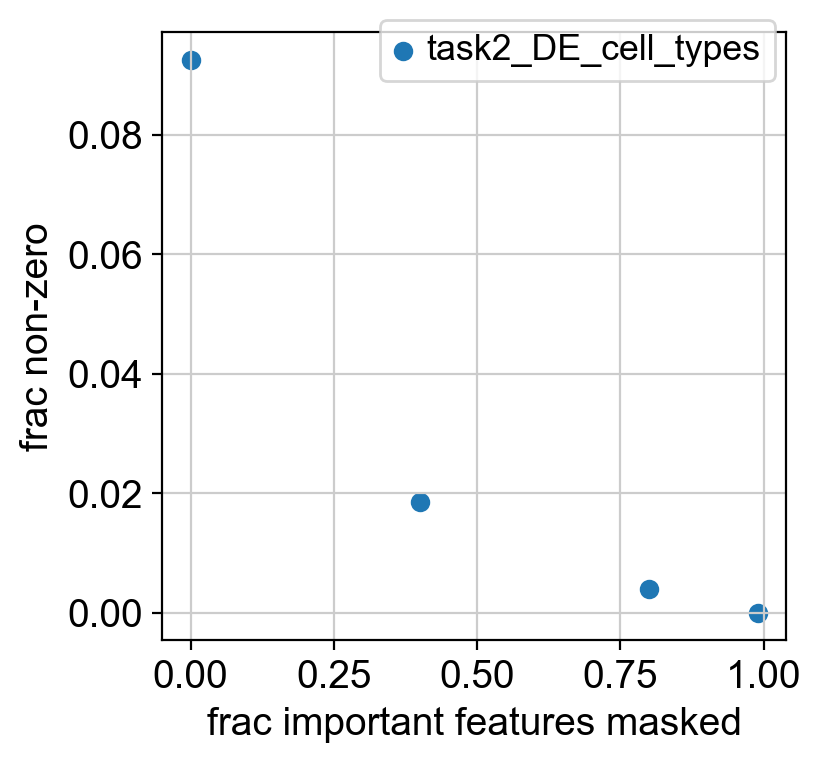

CPU times: user 7min 38s, sys: 21.4 s, total: 7min 59s
Wall time: 7min 32s


In [10]:
%%time
attribution_masks = {}
for feature_importance in feature_importance_files:
    
    print(feature_importance)
    attrib_df = pd.read_csv(feature_importance)
    
    # get rid of later
    attrib_df.columns = ['gene_symbols'] + list(attrib_df.columns[1:])
    
    # reverse order for DE
    if 'differential_expression' in feature_importance:
        attrib_df[attrib_df.columns[1:]] *= -1
    
    n_features = attrib_df.shape[0]
    if n_features < adata.shape[1]:
        raise ValueError(
            f"Attributions only calculated for {n_features} genes but adata has {adata.shape[1]}")
    elif n_features > adata.shape[1]:
        print(f'Only using attributions for {adata.shape[1]} genes.')
        attrib_df = attrib_df.set_index('gene_symbols').loc[adata.var_names].reset_index().rename({'index':'gene_symbols'}, axis=1)
    
    rankings, gene_indices = generate_rankings(attrib_df)  # probably should generate gene indices from adata or idk?
    attribution_masks[feature_importance.split("/")[-2]], incremental_sparsity = \
        generate_masked_inputs(rankings, gene_indices, attrib_df, thresholds)
    
    x, y = zip(*incremental_sparsity)
    plt.scatter(x, y, label=feature_importance.split('/')[-1].split('.')[0])

plt.ylabel('frac non-zero')
plt.xlabel('frac important features masked')
plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.show()

Sanity check - sparsity should decrease differently depending on ranking used.

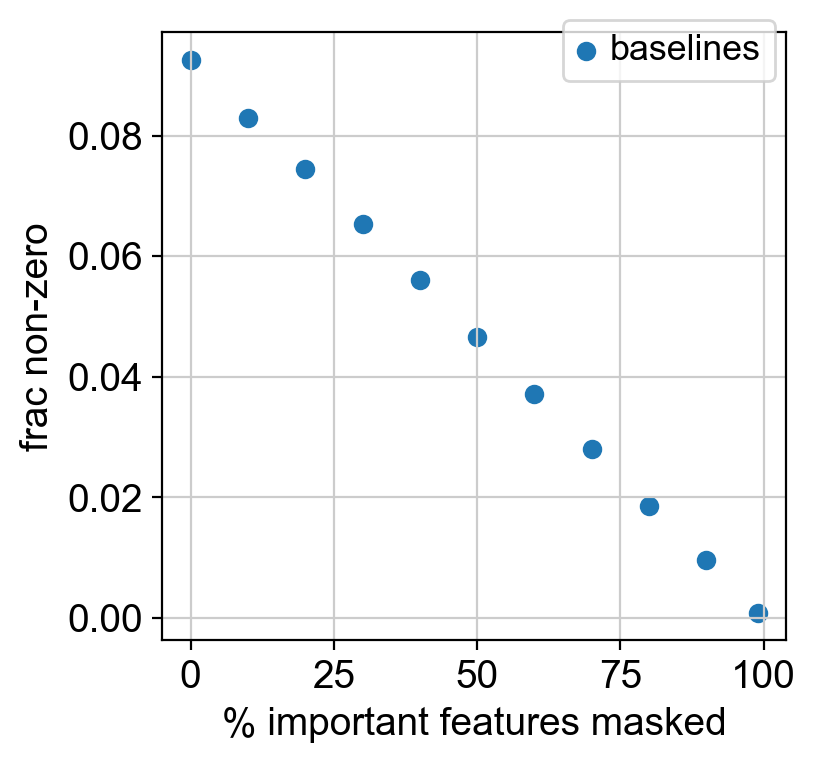

In [38]:
for k, masks_dict in attribution_masks.items():
    sparsity = []
    for threshold in thresholds:
        mask = attribution_masks[k][f'masked_{threshold}']
        sparsity.append(np.count_nonzero(mask) / (adata.shape[0] * adata.shape[1]))
    plt.scatter(thresholds, sparsity, label=k)
    
plt.ylabel('frac non-zero')
plt.xlabel('% important features masked')
plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.show()

## Pass to model

In [ ]:
%%time
for k, masks_dict in attribution_masks.items():
    for threshold in thresholds:
        obs_key = f'{k}_masked_{threshold}_pred'

        if obs_key in adata.obs.columns:
            continue
        
        adata.X = masks_dict[f'masked_{threshold}']
        X = model.get_latent_representation(adata)
        
        ref_emb = ad.AnnData(X, obs=adata.obs)
        print('calculating neighbors on ref embedding for', obs_key)
        sc.pp.neighbors(ref_emb, n_neighbors=30)

        print('label transfer')
        perform_label_transfer(
            ref_emb=ref_emb, query_emb=ref_emb, cell_type_column="scanvi_label"
        )
        
        adata.obs[obs_key] = ref_emb.obs['transf_scanvi_label'].copy()

calculating neighbors on ref embedding for differential_expression_masked_0_pred


Take a look at the last reference embedding, which is heavily masked.

In [60]:
%%time
sc.tl.umap(ref_emb)

CPU times: user 35min 51s, sys: 12min 14s, total: 48min 6s
Wall time: 10min 18s


/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


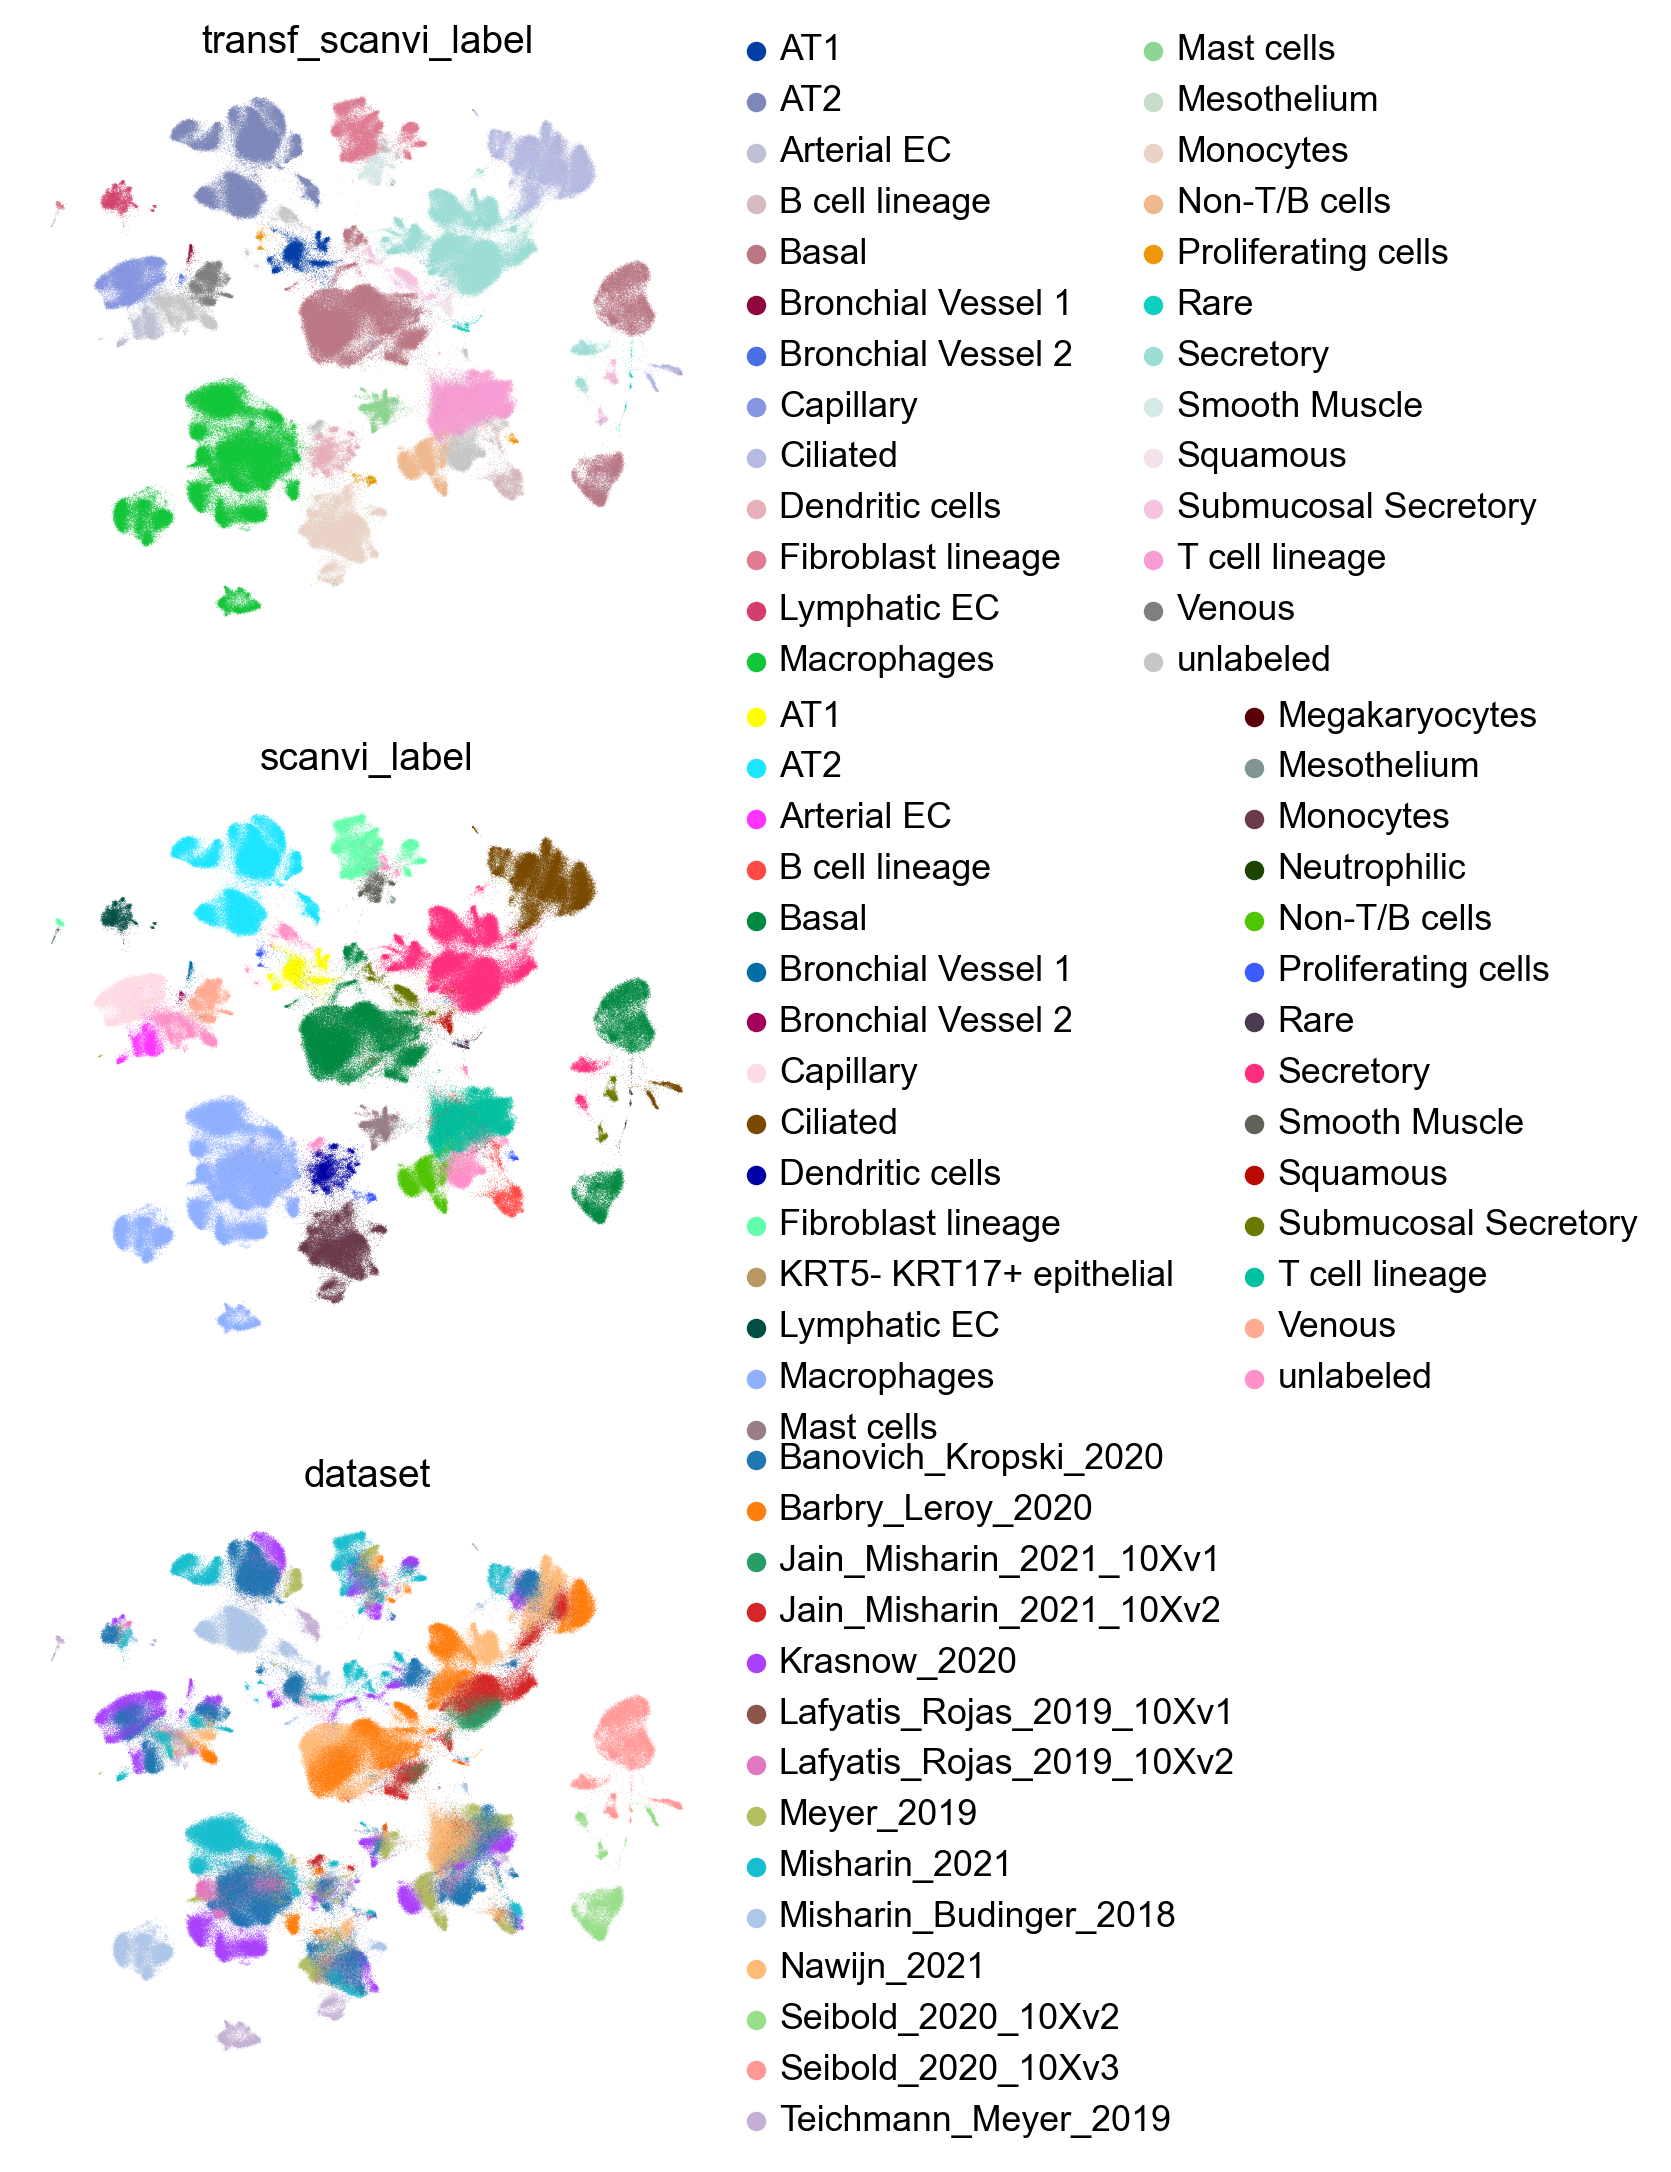

In [65]:
sc.pl.umap(ref_emb, color=['transf_scanvi_label', 'scanvi_label', 'dataset'], ncols=1)

In [63]:
adata.obs.to_csv('hlca_masking_res_random.csv')

## Plot performance metrics

In [14]:
df = pd.read_csv('hlca_masking_res_random.csv')

In [47]:
from sklearn.metrics import f1_score, classification_report

In [48]:
labels = adata.obs.scanvi_label.values
f1_scores = []
for k, masks_dict in attribution_masks.items():
    for threshold in thresholds:
        obs_key = f'{k}_masked_{threshold}_pred'
        
        if obs_key not in adata.obs.columns:
            print(obs_key, 'not found, skipping')
            continue
        
#         f1_scores.append(f1_score(labels, adata.obs[f'{k}_masked_{threshold}_pred'].values, average='macro'))
        print(classification_report(labels, adata.obs[f'{k}_masked_{threshold}_pred'].values))

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                         precision    recall  f1-score   support

                    AT1       0.93      0.88      0.91      9138
                    AT2       0.94      0.98      0.96     58398
            Arterial EC       0.85      0.77      0.81      6031
         B cell lineage       0.97      0.88      0.92      6361
                  Basal       0.89      0.95      0.92     93000
     Bronchial Vessel 1       0.91      0.63      0.74       455
     Bronchial Vessel 2       0.93      0.49      0.64       235
              Capillary       0.88      0.90      0.89     20597
               Ciliated       0.98      0.98      0.98     42295
        Dendritic cells       0.84      0.77      0.80      7813
     Fibroblast lineage       0.95      0.87      0.91     20549
KRT5- KRT17+ epithelial       0.00      0.00      0.00        11
           Lymphatic EC       0.94      0.91      0.92      4622
            Macrophages       0.93      0.94      0.94    106551
             Mast cells 

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                         precision    recall  f1-score   support

                    AT1       0.94      0.93      0.94      9138
                    AT2       0.96      0.99      0.97     58398
            Arterial EC       0.91      0.82      0.86      6031
         B cell lineage       0.96      0.90      0.93      6361
                  Basal       0.93      0.96      0.94     93000
     Bronchial Vessel 1       0.93      0.65      0.77       455
     Bronchial Vessel 2       0.95      0.53      0.68       235
              Capillary       0.88      0.93      0.90     20597
               Ciliated       0.98      0.98      0.98     42295
        Dendritic cells       0.90      0.83      0.87      7813
     Fibroblast lineage       0.95      0.92      0.94     20549
KRT5- KRT17+ epithelial       0.00      0.00      0.00        11
           Lymphatic EC       0.98      0.95      0.96      4622
            Macrophages       0.94      0.96      0.95    106551
             Mast cells 

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                         precision    recall  f1-score   support

                    AT1       0.96      0.94      0.95      9138
                    AT2       0.96      0.99      0.97     58398
            Arterial EC       0.95      0.85      0.90      6031
         B cell lineage       0.97      0.88      0.92      6361
                  Basal       0.95      0.97      0.96     93000
     Bronchial Vessel 1       0.95      0.69      0.80       455
     Bronchial Vessel 2       0.97      0.64      0.77       235
              Capillary       0.91      0.96      0.93     20597
               Ciliated       0.99      0.98      0.99     42295
        Dendritic cells       0.92      0.90      0.91      7813
     Fibroblast lineage       0.96      0.93      0.94     20549
KRT5- KRT17+ epithelial       0.00      0.00      0.00        11
           Lymphatic EC       0.96      0.95      0.96      4622
            Macrophages       0.96      0.97      0.97    106551
             Mast cells 

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                         precision    recall  f1-score   support

                    AT1       0.95      0.94      0.95      9138
                    AT2       0.97      0.99      0.98     58398
            Arterial EC       0.96      0.91      0.93      6031
         B cell lineage       0.98      0.89      0.93      6361
                  Basal       0.96      0.98      0.97     93000
     Bronchial Vessel 1       0.94      0.72      0.82       455
     Bronchial Vessel 2       0.96      0.69      0.81       235
              Capillary       0.92      0.94      0.93     20597
               Ciliated       0.99      0.98      0.99     42295
        Dendritic cells       0.96      0.88      0.92      7813
     Fibroblast lineage       0.96      0.96      0.96     20549
KRT5- KRT17+ epithelial       0.00      0.00      0.00        11
           Lymphatic EC       0.96      0.95      0.96      4622
            Macrophages       0.97      0.97      0.97    106551
             Mast cells 

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                         precision    recall  f1-score   support

                    AT1       0.97      0.96      0.97      9138
                    AT2       0.98      0.99      0.99     58398
            Arterial EC       0.97      0.93      0.95      6031
         B cell lineage       0.98      0.90      0.94      6361
                  Basal       0.97      0.98      0.98     93000
     Bronchial Vessel 1       0.97      0.71      0.82       455
     Bronchial Vessel 2       0.97      0.72      0.82       235
              Capillary       0.93      0.97      0.95     20597
               Ciliated       0.99      0.98      0.99     42295
        Dendritic cells       0.95      0.91      0.93      7813
     Fibroblast lineage       0.97      0.98      0.97     20549
KRT5- KRT17+ epithelial       0.00      0.00      0.00        11
           Lymphatic EC       0.97      0.96      0.97      4622
            Macrophages       0.98      0.99      0.98    106551
             Mast cells 

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                         precision    recall  f1-score   support

                    AT1       0.97      0.95      0.96      9138
                    AT2       0.98      0.99      0.99     58398
            Arterial EC       0.97      0.95      0.96      6031
         B cell lineage       0.99      0.91      0.95      6361
                  Basal       0.97      0.98      0.98     93000
     Bronchial Vessel 1       0.99      0.85      0.92       455
     Bronchial Vessel 2       0.97      0.78      0.87       235
              Capillary       0.95      0.97      0.96     20597
               Ciliated       0.99      0.98      0.99     42295
        Dendritic cells       0.96      0.88      0.92      7813
     Fibroblast lineage       0.97      0.98      0.98     20549
KRT5- KRT17+ epithelial       0.00      0.00      0.00        11
           Lymphatic EC       0.98      0.95      0.96      4622
            Macrophages       0.98      0.99      0.99    106551
             Mast cells 

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                         precision    recall  f1-score   support

                    AT1       0.97      0.95      0.96      9138
                    AT2       0.99      0.99      0.99     58398
            Arterial EC       0.98      0.97      0.97      6031
         B cell lineage       0.99      0.92      0.96      6361
                  Basal       0.98      0.99      0.98     93000
     Bronchial Vessel 1       0.98      0.94      0.96       455
     Bronchial Vessel 2       0.97      0.86      0.91       235
              Capillary       0.97      0.98      0.98     20597
               Ciliated       0.99      0.98      0.98     42295
        Dendritic cells       0.97      0.94      0.96      7813
     Fibroblast lineage       0.98      0.99      0.98     20549
KRT5- KRT17+ epithelial       1.00      0.09      0.17        11
           Lymphatic EC       0.99      0.96      0.98      4622
            Macrophages       0.99      1.00      0.99    106551
             Mast cells 

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

                    AT1       0.96      0.96      0.96      9138
                    AT2       0.98      0.99      0.99     58398
            Arterial EC       0.97      0.97      0.97      6031
         B cell lineage       0.98      0.88      0.93      6361
                  Basal       0.96      0.98      0.97     93000
     Bronchial Vessel 1       1.00      0.98      0.99       455
     Bronchial Vessel 2       0.98      0.91      0.94       235
              Capillary       0.98      0.99      0.98     20597
               Ciliated       0.99      0.97      0.98     42295
        Dendritic cells       0.98      0.96      0.97      7813
     Fibroblast lineage       0.98      0.97      0.98     20549
KRT5- KRT17+ epithelial       0.00      0.00      0.00        11
           Lymphatic EC       0.99      0.97      0.98      4622
            Macrophages       0.99      1.00      0.99    106551
             Mast cells 

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 0, '% features masked')

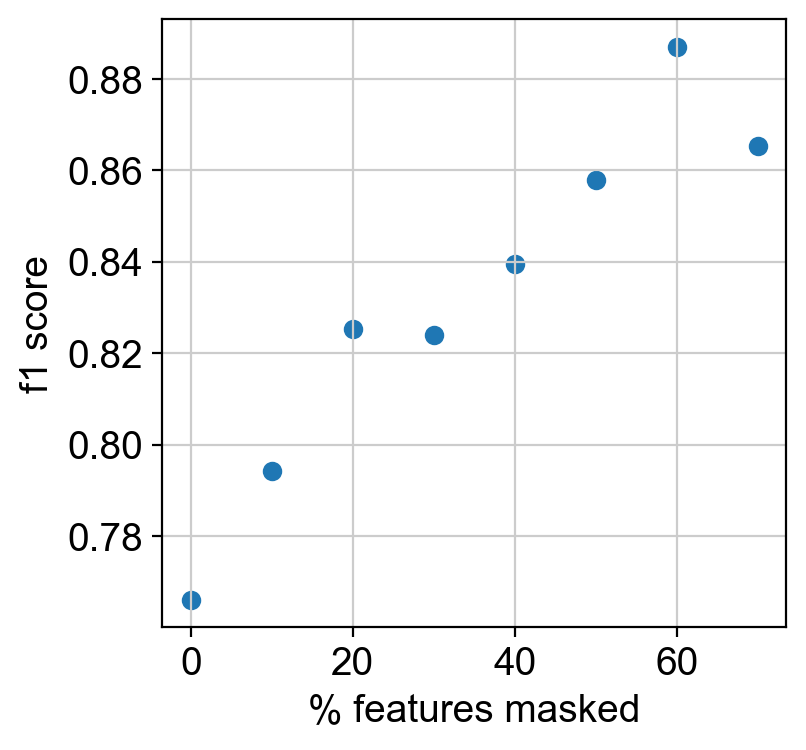

In [46]:
plt.scatter(thresholds[:-3], f1_scores, label='random')
plt.ylabel('f1 score')
plt.xlabel('% features masked')